### import modules

In [9]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits, ascii

params = {'text.usetex': False, 'mathtext.fontset': 'stixsans', 'font.family': 'sans-serif'}
plt.rcParams.update(params)


### Compute clumpy fraction for GOODS-N and GOODS-S together
Run the cell below as-is in order to obtain the results from de la Vega et al. (2025). 

In [10]:
# files containing 
clump_f_gds = ascii.read('./clump_finding_results/jades_gds_clumps_z_2_12_sigma_5_SNR_5_q_gtr_0p5_f444w_rhalf_0p1_rf_nuv_shibuya_selection.txt')
clump_f_gdn = ascii.read('./clump_finding_results/jades_gdn_clumps_z_2_12_sigma_5_SNR_5_q_gtr_0p5_f444w_rhalf_0p1_rf_nuv_shibuya_selection.txt')

z_bins = [2, 3.5, 5, 6.5, 12]
z_bin_width = np.array([0.75, 0.75, 0.75, 2.75])

m1, m2 = 9, 15
ssfr_limit = -9.5
flux_ratio_limits = [0.02, 0.02, 0.05, 0.07]

z_bin_mid = []
num_z_m9 = []
num_clumps_z_m9 = []

z_phot = []
z_spec = []

for i in range(len(z_bins) - 1):
    
    flux_ratio_limit = flux_ratio_limits[i]
    
    # GOODS-S
    z_crit_gds = (clump_f_gds['z'] >= z_bins[i]) & (clump_f_gds['z'] < z_bins[i+1]) &\
                 (clump_f_gds['log_mstar'] >= m1) & (clump_f_gds['log_mstar'] < m2) &\
                 (clump_f_gds['log_ssfr'] >= ssfr_limit)
    
    num_z_bin_gds = len(clump_f_gds[z_crit_gds])
    
    clump_crit_gds = (clump_f_gds['z'] >= z_bins[i]) & (clump_f_gds['z'] < z_bins[i+1]) &\
                     (clump_f_gds['number_clumps'] >= 1) &\
                     (clump_f_gds['log_mstar'] >= m1) & (clump_f_gds['log_mstar'] < m2) &\
                     (clump_f_gds['log_ssfr'] >= ssfr_limit) &\
                     (clump_f_gds['log_ssfr'] >= ssfr_limit) & (clump_f_gds['max_uv_flux_ratio'] >= flux_ratio_limit)
    
    num_clumps_z_bin_gds = len(clump_f_gds[clump_crit_gds])
    
    print('GDS', np.sum(clump_f_gds['number_clumps'][clump_crit_gds]), num_z_bin_gds, num_clumps_z_bin_gds)
    
    # GOODS-N
    z_crit_gdn = (clump_f_gdn['z'] >= z_bins[i]) & (clump_f_gdn['z'] < z_bins[i+1]) &\
                 (clump_f_gdn['log_mstar'] >= m1) & (clump_f_gdn['log_mstar'] < m2) &\
                 (clump_f_gdn['log_ssfr'] >= ssfr_limit)
    
    num_z_bin_gdn = len(clump_f_gdn[z_crit_gdn])
    
    clump_crit_gdn = (clump_f_gdn['z'] >= z_bins[i]) & (clump_f_gdn['z'] < z_bins[i+1]) &\
                     (clump_f_gdn['number_clumps'] >= 1) &\
                     (clump_f_gdn['log_mstar'] >= m1) & (clump_f_gdn['log_mstar'] < m2) &\
                     (clump_f_gdn['log_ssfr'] >= ssfr_limit) & (clump_f_gdn['max_uv_flux_ratio'] >= flux_ratio_limit)
    
    num_clumps_z_bin_gdn = len(clump_f_gdn[clump_crit_gdn])
    
    zmin, zmax = z_bins[i], z_bins[i+1]
    z_bin_mid.append( np.mean([zmin, zmax]) )
    
    num_z_m9.append(num_z_bin_gds + num_z_bin_gdn)
    num_clumps_z_m9.append(num_clumps_z_bin_gds + num_clumps_z_bin_gdn)
    
    print('GDN', np.sum(clump_f_gdn['number_clumps'][clump_crit_gdn]), num_z_bin_gdn, num_clumps_z_bin_gdn)
    
z_bin_mid = np.asarray(z_bin_mid)
num_z_m9 = np.asarray(num_z_m9)
num_clumps_z_m9 = np.asarray(num_clumps_z_m9)

print(num_clumps_z_m9)
print(num_z_m9)

# computing Bayesian binomial confidence intervals
ci_lower, ci_upper = binom_conf_interval(k=num_clumps_z_m9, n=num_z_m9, interval='jeffreys')

print(ci_lower)
print(ci_upper)

GDS 1632 531 399
GDN 1348 500 374
GDS 495 235 152
GDN 240 180 109
GDS 44 47 18
GDN 53 71 29
GDS 6 15 4
GDN 5 25 5
[773 261  47   9]
[1031  415  118   40]
[0.73603049 0.60491843 0.35428055 0.16632886]
[0.76300032 0.65229251 0.44404455 0.29722394]


### Compute clumpy fraction for GOODS-N and GOODS-S separately
Run the cell below as-is in order to obtain the results from de la Vega et al. (2025). 

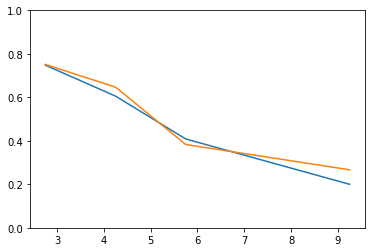

[0.75141243 0.64680851 0.38297872 0.26666667]
[0.748      0.60555556 0.4084507  0.2       ]
[0.74975752 0.62891566 0.39830508 0.225     ]


In [11]:
num_z_m9_gds = np.array([531, 235, 47, 15])
num_clumps_z_m9_gds = np.array([399, 152, 18, 4])
ci_lower_gds, ci_upper_gds = binom_conf_interval(k=num_clumps_z_m9_gds, n=num_z_m9_gds, interval='jeffreys')

num_z_m9_gdn = np.array([500, 180, 71, 25])
num_clumps_z_m9_gdn = np.array([374, 109, 29, 5])
ci_lower_gdn, ci_upper_gdn = binom_conf_interval(k=num_clumps_z_m9_gdn, n=num_z_m9_gdn, interval='jeffreys')

plt.plot( z_bin_mid, num_clumps_z_m9_gdn / num_z_m9_gdn )
plt.plot( z_bin_mid, num_clumps_z_m9_gds / num_z_m9_gds )

plt.ylim(0, 1)

plt.show()

print( num_clumps_z_m9_gds / num_z_m9_gds )
print( num_clumps_z_m9_gdn / num_z_m9_gdn )
print(num_clumps_z_m9 / num_z_m9)

### Function for the cosmic SFR density from Madau & Dickinson (2014)

In [12]:
def sfr_dens(z):
    return 0.015 * ((1+z) ** 2.7) / (1+((1+z)/2.9) ** 5.6)

### Reproduce Fig. 7 from de la Vega et al. (2025)

[2.75 4.25 5.75 9.25] [773 261  47   9] [1031  415  118   40]
[0.74975752 0.62891566 0.39830508 0.225     ]


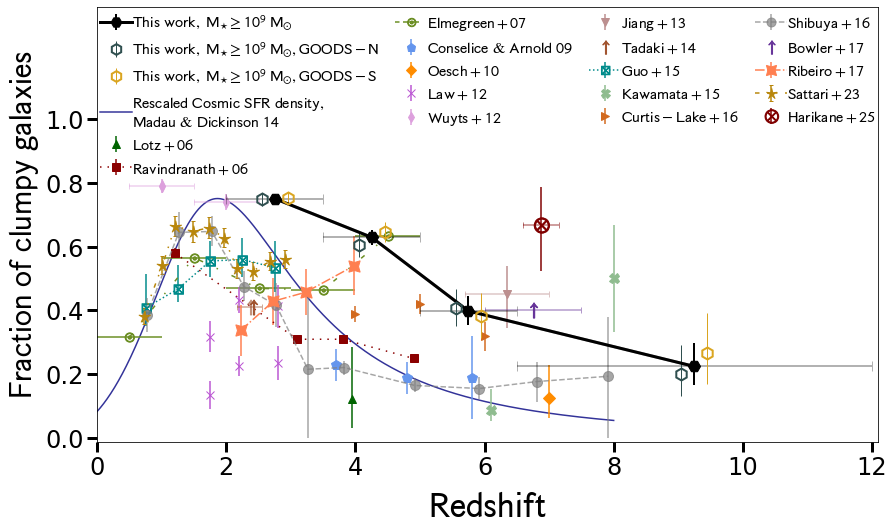

In [13]:
print(z_bin_mid, num_clumps_z_m9, num_z_m9)
print(num_clumps_z_m9 / num_z_m9)

# begin figure
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(14)

# results of this work, both fields combined
ci_lower, ci_upper = binom_conf_interval(k=num_clumps_z_m9, n=num_z_m9, interval='jeffreys')

plt.errorbar( z_bin_mid, (num_clumps_z_m9 / num_z_m9),
            yerr=[(num_clumps_z_m9 / num_z_m9 - ci_lower), (ci_upper - num_clumps_z_m9 / num_z_m9)],
            marker='H', markersize=12, linestyle='-', c='k', lw=3, elinewidth=2., label=r'$\rm{This~work, ~M_{\star}\geq 10^9~M_{\odot}}$', zorder=2)

plt.errorbar( z_bin_mid, (num_clumps_z_m9 / num_z_m9),
            xerr=[z_bin_width],
            marker='H', markersize=12, linestyle='-', c='k', lw=3, elinewidth=2., capsize=5, alpha=0.3, label=None, zorder=2)

# results of this work, GOODS-N
plt.errorbar( z_bin_mid - 0.2, (num_clumps_z_m9_gdn / num_z_m9_gdn),
            yerr=[(num_clumps_z_m9_gdn / num_z_m9_gdn - ci_lower_gdn), (ci_upper_gdn - num_clumps_z_m9_gdn / num_z_m9_gdn)],
            marker='h', markersize=12, linestyle='None', c='darkslategray', lw=1, elinewidth=1., markerfacecolor='None', ecolor='darkslategray',
             label=r'$\rm{This~work, ~M_{\star}\geq 10^9~M_{\odot}, GOODS-N}$', markeredgewidth=2., zorder=2)

# results of this work, GOODS-S
plt.errorbar( z_bin_mid + 0.2, (num_clumps_z_m9_gds / num_z_m9_gds),
            yerr=[(num_clumps_z_m9_gds / num_z_m9_gds - ci_lower_gds), (ci_upper_gds - num_clumps_z_m9_gds / num_z_m9_gds)],
            marker='h', markersize=12, linestyle='None', c='goldenrod', lw=1, elinewidth=1., markerfacecolor='None', ecolor='goldenrod',
             label=r'$\rm{This~work, ~M_{\star}\geq 10^9~M_{\odot}, GOODS-S}$', markeredgewidth=2., zorder=2)

# cosmic SFRD from Madau & Dickinson 14
# using errorbar here as a shortcut- apparently, plt.plot() is prioritized over plt.errorbar() when using
# plt.legend() with default settings
zs = np.linspace(0, 8, 801)
plt.errorbar(zs, 0.75 * sfr_dens(zs) / np.max(sfr_dens(zs)), color='navy', 
         linestyle='-', alpha=0.8, marker=None,
             label=r'$\rm{Rescaled~Cosmic~SFR~density,}$' + '\n' + r'$\rm{Madau~&~Dickinson~14}$', zorder=0)

# set axis limits and tick label parameters
plt.ylim(-0.01, 1.35)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xlim(0, 12.1)
plt.tick_params(labelsize=24, length=10, width=3)

# axis labels
plt.ylabel(r'$\rm{Fraction~of~clumpy~galaxies}$', size=32)
plt.text(0.5, -0.15, r'$\rm{Redshift}$', size=36, ha='center', va='center', transform=plt.gca().transAxes)

# results from earlier studies below

# data from Lotz+06, their Table 1
z_lot06_tab2 = np.array([4.0 - 0.05])
lot06_frac = np.array([0.1219])
lot06_num = np.array([82])

ci_lower, ci_upper = binom_conf_interval(k=10, n=82, interval='jeffreys')

plt.errorbar( z_lot06_tab2, lot06_frac, 
             yerr=[[ci_lower], [ci_upper]], 
             linestyle='None', marker='^', markersize=8, color='darkgreen', label=r'$\rm{Lotz+06}$', zorder=1)

# data from Ravindranath+06, their Table 2
z_rav06_tab2 = np.array([1.2, 3.1, 3.8, 4.9])
rav06_frac = np.array([0.58, 0.31, 0.31, 0.25])
rav06_num = np.array([1025, 1409, 2440, 845])

ci_lower, ci_upper = binom_conf_interval(k=np.array([594, 437, 756, 211]), n=rav06_num, interval='jeffreys')

plt.errorbar( z_rav06_tab2, rav06_frac, 
             yerr=[rav06_frac - ci_lower, ci_upper - rav06_frac], 
             linestyle=(0, (1, 4)), marker='s', markersize=8, color='darkred', label=r'$\rm{Ravindranath+06}$', zorder=1)

# results from Elmegreen+07, their Fig. 6
z_elm07 = np.array([0.5, 1.5, 2.5, 3.5, 4.5])
elm07_frac = np.array([2.495/(2.495+1.293+4.097), 1.22/(1.22+0.161+0.7767), 0.485/(0.485+0.044+0.5049), 0.417/(0.417+0.190+0.291), 0.184/(0.184+0.049+0.058)])

plt.errorbar( z_elm07, elm07_frac, 
             xerr=[0.5], 
             linestyle=(0, (3, 10, 1, 10)), marker=r'$\circledcirc$', markersize=10, color='olivedrab', label=r'$\rm{Elmegreen+07}$', zorder=1)

# results from Conselice & Arnold 09, their Table 2
z_ca09_tab2 = np.array([3.7, 4.8, 5.8])
ca09_frac = np.array([0.23, 0.19, 0.19])
ca09_frac_err = np.array([0.05, 0.05, 0.13])

plt.errorbar( z_ca09_tab2, ca09_frac, 
             yerr=ca09_frac_err, 
             linestyle='None', marker='p', markersize=10, color='cornflowerblue', label=r'$\rm{Conselice~&~Arnold~09}$', zorder=1)

# results from Oesch+10, their Summary
z_oes10 = np.array([7.])
oes10_frac = np.array([0.125])
oes10_num = np.array([16])

ci_lower, ci_upper = binom_conf_interval(k=2, n=16, interval='jeffreys')

plt.errorbar( z_oes10, oes10_frac, 
             yerr=[oes10_frac - [ci_lower], [ci_upper] - oes10_frac],
             linestyle='None', marker='D', markersize=8, color='darkorange', label=r'$\rm{Oesch+10}$', zorder=1)

# results from Law+12, their Fig. 17, fractions based on Asymmetry
z_law12 = np.array([1.7, 2.15, 2.75]) + 0.05
law12_frac = np.array([0.3179, 0.4316, 0.4128])
law12_frac_err = np.array([0.2695, 0.3913, 0.3465])

plt.errorbar( z_law12, law12_frac, 
             yerr=[law12_frac - law12_frac_err], 
             linestyle='None', marker='x', markersize=8, color='mediumorchid', label=r'$\rm{Law+12}$', zorder=1)

# results from Law+12, their Fig. 17, fractions based on Gini-M20
z_law12 = np.array([1.7, 2.15, 2.75]) + 0.05
law12_frac = np.array([0.136, 0.2265, 0.2355])
law12_frac_err = np.array([0.093, 0.196, 0.183])

plt.errorbar( z_law12, law12_frac, 
             yerr=[law12_frac - law12_frac_err], 
             linestyle='None', marker='x', markersize=8, color='mediumorchid', label=None, zorder=1)

# results from Wuyts+12, their Table 1
z_wu12 = np.array([1., 2.])
wu12_frac = np.array([0.79, 0.74])
wu12_num = np.array([323, 326])

ci_lower, ci_upper = binom_conf_interval(k=[255, 241], n=wu12_num, interval='jeffreys')

plt.errorbar( z_wu12, wu12_frac, 
             yerr=[wu12_frac - ci_lower, ci_upper - wu12_frac], 
             linestyle='None', marker='d', markersize=8, color='plum', label=r'$\rm{Wuyts+12}$', zorder=1)

plt.errorbar( z_wu12, wu12_frac, xerr=[0.5, 0.5], alpha=0.5, capsize=3,
             linestyle='None', marker='d', markersize=8, color='plum', label=None, zorder=1)

# results from Jiang+13, their Section 3.3
z_ji13 = np.array([6.35])
ji13_frac = np.array([0.45])
ji13_num = np.array([25.])

ci_lower, ci_upper = binom_conf_interval(k=[11], n=ji13_num, interval='jeffreys')

plt.errorbar( z_ji13, ji13_frac, 
             yerr=[ji13_frac - ci_lower, ci_upper - ji13_frac], 
             linestyle='None', marker='v', markersize=8, color='rosybrown', label=r'$\rm{Jiang+13}$', zorder=1)

plt.errorbar( z_ji13, ji13_frac, 
             xerr=[0.65], alpha=0.5,
             linestyle='None', marker='v', markersize=8, color='rosybrown', label=None, capsize=3, zorder=1)

# results from Tadaki+14, their Sec. 3.1
plt.errorbar( 2.36 + 0.05, 0.41,
             linestyle='None', marker=r'$\uparrow$', markersize=15, color='sienna', label=r'$\rm{Tadaki+14}$', zorder=1)

plt.errorbar( 2.36, 0.41, xerr=[0.19], alpha=0.5, capsize=3,
             linestyle='None', marker=r'$\uparrow$', markersize=15, color='sienna', label=None, zorder=1)

# results from Guo+15, their Fig. 10, intermediate masses
z_guo15 = np.array([0.75, 1.25, 1.75, 2.25, 2.75])
guo15_frac = np.array([0.408, 0.467, 0.555, 0.559, 0.534])
guo15_frac_err_low = np.array([0.3499, 0.4263, 0.5042, 0.5056, 0.4589,])
guo15_frac_err_high = np.array([0.5142, 0.5425, 0.6161, 0.6275, 0.6176])

plt.errorbar( z_guo15, guo15_frac, 
             yerr=[guo15_frac - guo15_frac_err_low, guo15_frac_err_high - guo15_frac], 
             linestyle=':', marker=r'$\boxtimes$', markersize=10, color='darkcyan', label=r'$\rm{Guo+15}$', zorder=1)

# results from Kawamata+15, their Sec. 3.1 and Figs. A1-A6
z_kaw15 = np.array([6.1, 8.0])
kaw15_frac = np.array([0.09, 0.5])
kaw15_num = np.array([33, 8])

ci_lower, ci_upper = binom_conf_interval(k=[3, 4], n=kaw15_num, interval='jeffreys')

plt.errorbar( z_kaw15, kaw15_frac, 
             yerr=[kaw15_frac - ci_lower, ci_upper - kaw15_frac], 
             linestyle='None', marker='X', markersize=10, color='darkseagreen', label=r'$\rm{Kawamata+15}$', zorder=1)


# results from Curtis-Lake+16, their Figure 17
z_cu16 = np.array([4, 5, 6])
cu16_frac = np.array([0.39, 0.42, 0.319])
cu16_frac_err = np.array([0.365, 0.389, 0.2747])

plt.errorbar( z_cu16, cu16_frac, 
             yerr=cu16_frac - cu16_frac_err, 
             linestyle='None', marker='>', markersize=8, color='chocolate', label=r'$\rm{Curtis-Lake+16}$', zorder=1)

# results from Shibuya+16, their Fig 4
z_shibuya16_fig4 = np.linspace(0.5, 8, 76)

shibuya_16_z = [0.7658, 1.2653, 1.773, 2.2726, 2.7721, 3.2632, 3.8210, 4.9198, 5.9188, 6.81789, 7.91675]
shibuya_clump_frac = np.array([0.38440, 0.6443, 0.64705, 0.47469, 0.41586, 0.21614, 0.22161, 0.165526, 0.15595, 0.17783, 0.19425])
shibuya_clump_frac_lower_err = np.array([0.33242, 0.58002, 0.601915, 0.430916, 0.34883, 0., 0.199726, 0.145006, 0.12175, 0.11491, 0.])
shibuya_clump_frac_upper_err = np.array([0.43912, 0.70725, 0.694938, 0.522571, 0.485636, 0.443228, 0.242134, 0.187414, 0.191518, 0.23803, 0.37893])

plt.errorbar( shibuya_16_z, shibuya_clump_frac,
            yerr=[shibuya_clump_frac - shibuya_clump_frac_lower_err, shibuya_clump_frac_upper_err - shibuya_clump_frac],
            marker='o', markersize=10, linestyle='--', c='grey', alpha=0.7, zorder=1, 
            label=r'$\rm{Shibuya+16}$')

# results from Bowler+17, their Sec. 4.4
plt.errorbar( 6.75, 0.4,
             linestyle='None', marker=r'$\uparrow$', markersize=15, color='rebeccapurple', label=r'$\rm{Bowler+17}$', zorder=1)

plt.errorbar( 6.75, 0.4, xerr=[0.75], alpha=0.5, capsize=3,
             linestyle='None', marker=r'$\uparrow$', markersize=15, color='rebeccapurple', label=None, zorder=1)

# results from Ribeiro+17, their Figure 8
z_rib17 = np.array([2.2250879249706914, 2.7291910902696364, 3.2274325908558033, 3.977725674091442])
rib17_frac = np.array([0.33793103448275863, 0.4289655172413793, 0.4568965517241379, 0.5396551724137931])
rib17_frac_err = np.array([0.4186206896551724, 0.5024137931034482, 0.5293103448275862, 0.6317241379310344]) - rib17_frac


plt.errorbar( z_rib17, rib17_frac, yerr=rib17_frac_err,
             linestyle='-.', marker=(4, 1, 45), markersize=16, color='coral', label=r'$\rm{Ribeiro+17}$', zorder=1)

# results from Sattari+23, their Fig 7
z_sat23 = np.array([0.72, 1.01, 1.21, 1.48, 1.73, 1.96, 2.166, 2.413, 2.683, 2.903])
sat23_frac = np.array([0.3835, 0.541, 0.6649, 0.6471, 0.659, 0.628, 0.532, 0.524, 0.554, 0.560])
sat23_frac_err = np.array([0.358, 0.513, 0.634, 0.615, 0.627, 0.597, 0.503, 0.495, 0.526, 0.532])

plt.errorbar( z_sat23, sat23_frac, yerr=[sat23_frac - sat23_frac_err],
             linestyle=(0, (3, 5, 1, 5, 1, 5)), marker=r'$\star$', markersize=12, 
             color='darkgoldenrod', label=r'$\rm{Sattari+23}$', zorder=1, capsize=2)

# results from Harikane+25, their Section 4.1
ci_lower, ci_upper = binom_conf_interval(k=[8], n=[12], interval='jeffreys')

plt.errorbar( 6.8745, [8. / 12.], yerr=[(8. / 12. - ci_lower), (ci_upper - 8. / 12.)], 
             marker=r'$\bigotimes$', markersize=16, color='maroon', label=r'$\rm{Harikane+25}$', linestyle='None', zorder=1 )

plt.errorbar( 6.8745, [8. / 12.], xerr=0.2795, alpha=0.5,
             marker=r'$\bigotimes$', markersize=16, color='maroon', label=None, capsize=3, zorder=1 )

plt.legend(loc='upper center', fontsize=16, handletextpad=0., 
           markerscale=0.9, frameon=False, ncol=4, columnspacing=1,
           borderaxespad=0.0)

#plt.savefig('./clump_fraction_shibuya_selection_JADES_GDS_GDN_rf_NUV_bagpipes_fits.jpg', format='jpg', dpi=150, bbox_inches='tight')

plt.show()
